In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
def enum_other_states(n, num_step):
    """enumerate the state. using the following invariants
    (1) symetry (.1,.1,.8) is equivalent to (.1,.1,.8) from firm 1's pespective
    (2) the states must sum to 1"""
    
    states_i = np.arange(0,num_step+1)*(1./num_step)
    if n <=1:
        return states_i.reshape(num_step+1,1)
    else:
        states = []
        states_j = enum_other_states(n-1, num_step)
        for i in states_i:
            for j in states_j:
                if j[0] >= i and (j.sum() + i <= 1):
                    state_ij = np.concatenate( ([i],j) )
                    states.append(state_ij)
        states = np.array(states)
        return  states
    
    
def make_3d(np_array):
    """make a 2d np array 3d"""
    return np.array(np_array).reshape((len(np_array),1))

In [3]:
class States:
    """class for dealing with the states to ensure
    invariants are kept"""
    
    my_states = None #type nparray
    other_states = None #type np array 2d
    n = 0 #number of players
    num_step = 0 #number of states (states normalized between 0 and 1)
    types = None

    def __init__(self, n, num_step):
        """initialize important class attributes"""
        self.n, self.num_step = n, num_step
      
    
    def gen_states(self):
        """compute all relevant states for firm i (Avoiding side effects)
        the trick is enforcing invariants in the helper"""
        
        new_states = States(self.n, self.num_step)
        other_states =  enum_other_states(self.n-1, self.num_step)
        my_states = 1 - other_states.sum(axis=1)
        
        #initialize the 'type'
        new_states.types = np.tile([0,1],len(my_states))
        new_states.my_states = np.repeat(my_states,2)
        new_states.other_states = np.repeat(other_states,2,axis=0)
        
        return new_states
    
    
    def get_all(self,  types=False, filter_types=None, order=False):
        """return various attributes as an array"""
        other_states = self.other_states
        if order: other_states = np.sort(self.other_states)
        
        reshaped_states = make_3d(self.my_states)
        all_states = np.concatenate( (reshaped_states, other_states), axis=1 )
        
        #add types if needed
        if types:
            reshaped_types = make_3d(self.types)
            all_states = np.concatenate( (all_states,reshaped_types), axis=1 )
        
        #filter certain types
        if filter_types == None:
            return all_states
        else:
            return all_states[self.types == types ]
    
    
    def get_len(self):
        """qaulity of life, len of states"""
        return len(self.other_states)
    
    
    def make_states(self, my_states, other_states, types):
        """special initializer for states enforcing the invariants"""
        assert np.array(other_states).shape[1] == (self.n -1)
        #make a copy to avoid side effects
        new_states = States(self.n, self.num_step)
        
        #combine into 1 array
        my_states = make_3d(my_states)
        all_states = np.concatenate((my_states,other_states),axis=1)
        all_states = np.maximum(0, all_states )

        #re-weight states
        denom = all_states.sum(axis=1)
        denom = np.repeat(denom,self.n).reshape(all_states.shape)
        all_states = all_states/denom
        
        #return states
        new_states.types = np.clip(np.array(types).astype(int),0,1)
        new_states.my_states = all_states[:,0]
        new_states.other_states = np.delete(all_states,0,axis=1)
        
        return new_states

In [4]:
def set_up_env(n, nsim, steps, params):
    """generate reasonable parameters for simulations
    
    theta0 - mean costs; 
    theta1 - returns to scale
    theta2 - lower cost
    theta3 - drs
    
    we need to have theta0 < theta2
    
    theta4 - forgivness probability
    theta5 - size of contracts """
    
    states = States(n, steps).gen_states()
    
    #set up shocks
    var_cost = 1.2/steps
    cost_shocks = np.random.normal(0,var_cost,(nsim,n))
    type_shocks = np.random.binomial(1, params[4], size=(nsim,1))
    shocks = np.concatenate((cost_shocks,type_shocks),axis=1)
    
    #set up bids
    bsteps = int(1.1*steps)
    min_bid = params[2] - 2*var_cost
    max_bid = params[0] + params[1] + 3*var_cost
    bid_weighting = (max_bid - min_bid)/(bsteps)
    bids = min_bid + np.arange(1,bsteps)*bid_weighting

    policy = lambda state, shock: 4*state.types
    value = lambda state: 4*state.types
    
    return value, policy, bids, states, shocks, params


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)

In [5]:
def cost(states, shocks, params):
    """return the cost for all firms based on states"""
    all_types = make_3d(states.types)
    all_types = np.tile(all_types, (1,states.n))
    
    c1 = params[0] + params[1]*states.get_all()
    c2 = params[2] + params[3]*states.get_all()
    
    return c1*(1-all_types) + c2*(all_types) + shocks[:,:-1]


def weighting(bids):
    """return weighting when there's a tie"""
    n_states, n_players = bids.shape
    low_bid =  np.min(bids,axis=1)
    low_bid = np.repeat(low_bid, n_players).reshape(n_states,n_players)
    
    #winners
    win = (bids <= low_bid)
    n_winners = win.sum(axis=1)*1.
    n_winners = np.repeat(n_winners, n_players).reshape(n_states,n_players)
    
    #add loosers
    lose = (bids > low_bid)
    n_loosers = np.maximum(lose.sum(axis=1)*1.,1.)
    n_loosers = np.repeat(n_loosers, n_players).reshape(n_states,n_players)
    
    return win/(1.*n_winners), lose/(1.*n_loosers)


def profit(bids, states, shocks, params):
    """return firm 0's profit"""
    bids,shocks = np.array(bids),np.array(shocks)
    win_weights, lose_weights = weighting(bids)
    profits = params[5]*win_weights*(bids - cost(states,shocks,params))  
    return profits


def update_state(bids, states, params):
    """update all firms states based on bids
    note: firms in updated states, no longer correspond to their bids"""
    bids = np.array(bids)
    
    win_weights, lose_weights = weighting(bids)
    new_states = params[5]*win_weights - params[5]*lose_weights + states.get_all()
    return states.make_states(new_states[:,0],new_states[:,1:], states.types)


####unit testing######

params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
states = States(3,4)
new_states = states.make_states([.6,.6],[[.2,.2],[.2,.2]],[0,1])
new_shocks = np.array([[0,0,0,0],[0,0,0,0]])


print cost(new_states, new_shocks, params)
print profit([[2,1,2],[2,1,2]], new_states, new_shocks, params)
print update_state([[2,1,2],[2,1,2]], new_states, params).get_all(types=True)

[[2.32 2.44 2.44]
 [2.12 2.04 2.04]]
[[-0.    -0.144 -0.   ]
 [-0.    -0.104 -0.   ]]
[[0.55 0.3  0.15 0.  ]
 [0.55 0.3  0.15 1.  ]]


In [53]:
def gen_all_states(bids, states, shocks):
    """tile the states B x NSIM times"""
    #save lengths for later 
    n_bids, n_shocks = bids.shape[0], shocks.shape[0]
    
    #duplicate states
    all_states = states.get_all(types=True)
    all_states = np.tile(all_states,(n_bids*n_shocks,1))
    all_states = states.make_states(all_states[:,0],all_states[:,1:-1],all_states[:,-1])
    
    shocks = np.repeat(shocks, states.get_len(), axis=0)
    shocks = np.tile(shocks,(n_bids,1))
    my_bids = np.repeat(bids,states.get_len()*n_shocks)
    
    return my_bids, all_states, shocks


def gen_all_shocks(states, shocks):
    """do the same thing but return the states and shocks as sepperate objects"""
    n_shocks = shocks.shape[0]
    all_shocks = np.repeat(shocks, states.get_len(), axis=0)
    all_states = np.tile(states.get_all(types=True),(n_shocks,1))
    all_states = states.make_states(all_states[:,0],all_states[:,1:-1], all_states[:,-1])
    
    #update types here?
    all_states.types = np.maximum(all_states.types, all_shocks[:,-1])
    return all_states, all_shocks

In [54]:
def flip_states(states,i):
    """flip states from perspective of i"""
    other_states = states.get_all()
    i_state = other_states[:,i]
    i_other = np.delete(other_states, i, axis=1)
    other_states = states.make_states(i_state, i_other, states.types)
    return other_states


def calc_bids(policy, states, shocks, start=1):
    """return the other players bids given 
    the state by 'switching perspective' to other firm"""

    other_bids = []
    for i in range(start,states.n):
        other_states = flip_states(states,i)
        i_shocks = shocks[:,:-1].take(np.arange(states.n) + i, mode='wrap', axis=1)
        i_shocks = np.concatenate((i_shocks, shocks[:,-1:]), axis=1)
        i_bid = policy(other_states, i_shocks)
        other_bids.append( i_bid )
    
    return np.array(other_bids).transpose()


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
new_states = states.make_states([.6,.6],[[.2,.2],[.2,.2]],[0,1])
new_shocks = np.array([[0,0,0,1],[0,0,0,0]])
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)
print calc_bids(policy, new_states, new_shocks)

[[0.4 0.4]
 [2.4 2.4]]


In [55]:
def policy_operator(init_value, init_policy, bids, states, shocks, params):
    """run a simulatio for just 1 type to recalculate value function
    returns his value from each simulated state"""
    
    n_bids, n_shocks = bids.shape[0], shocks.shape[0]
    
    #generate all bids x sims x states
    my_bids, all_states, all_shocks = gen_all_states( bids, states, shocks)
    
    #other bids in each bid state and concat with my bids
    other_bids = calc_bids(init_policy, all_states, all_shocks)
    all_bids = my_bids.reshape(all_states.get_len(),1)
    all_bids = np.concatenate((all_bids, other_bids), axis=1)
    
    #calculate see how the states would update
    next_states = update_state(all_bids, all_states, params)
    
    #calculate the value of the next state
    value_matrix = profit(all_bids, all_states, all_shocks, params)[:,0]
    value_matrix = value_matrix + params[-1]*init_value(next_states)
    
    #set up matrix for policy
    policy_matrix = value_matrix.reshape(n_bids, states.get_len()*n_shocks )
    policy_matrix = np.argmax(policy_matrix ,axis=0)
    policy_matrix = bids[policy_matrix]
    
    all_states, all_shocks = gen_all_shocks(states, shocks)
    all_shocks =  np.concatenate( (all_states.get_all(types=True,order=True),all_shocks), axis=1)
    
    return lambda s0, e0: griddata(all_shocks, policy_matrix, 
                                   np.concatenate( (s0.get_all(types=True,order=True),e0), axis=1),
                                   method='nearest',rescale=True)


#### unit testing ####

params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)
policy = policy_operator(value, policy, bids, states, shocks, params)

new_states = states.make_states([.6,.6],[[.3,.2],[.2,.3]],[1,0])
new_shocks = np.array([[0,0,0,0],[0,0,0,1]])


policy(new_states,new_shocks)

array([2.66666667, 1.93333333])

In [63]:
def ic_policy_helper(value, policy, bids, states, shocks, params):
    """return the other players values given 
    the state by 'switching perspective' to other firm"""
    
    #states and shocks different lengths
    all_states, all_shocks = gen_all_shocks(states, shocks)
    
    bids_step = bids[1] - bids[0]
    all_bids = calc_bids(policy,  all_states, all_shocks, start=0) 
    next_states = update_state(all_bids, all_states, params)
    all_profit = profit(all_bids, all_states, all_shocks, params)
    min_bid = all_bids.min(axis=1)
    
    #all states, but with the lower cost function
    dev_states = all_states.make_states(all_states.my_states, all_states.other_states, 
                                        np.ones(all_states.get_len()))
    all_ic = [] #ic constraints for each player
    
    for i in range(0,states.n):

        #figure out collusive profits for i
        col_states = flip_states(all_states,i)
        col_next = flip_states(next_states,i)
        col_profit = all_profit[:,i] + params[-1]*value(col_next)
        
        #evaluate a deviation for i
        dev_bids = all_bids
        dev_bids[:,i] = np.minimum(min_bid - bids_step, bids[0]) #bidder i wins instead
        dev_next = update_state(dev_bids, all_states, params)
        dev_next.types = dev_next.types*0
        
        #win the auction with the lower costs
        dev_profits = profit(dev_bids, dev_states, all_shocks, params)[:,i]
        dev_profits = dev_profits + params[-1]*value(dev_next)
        
        all_ic.append( (col_profit >= dev_profits) )
    
    #generate new policy that is incentive compatible
    all_ic = np.array(all_ic)
    ic = all_ic.min(axis=0)
    
    #update type
    new_types = np.minimum(all_states.types,ic)
    new_states = states.make_states(all_states.my_states,all_states.other_states, new_types)
    
    policy_matrix = policy(new_states, all_shocks)
    all_shocks =  np.concatenate( (all_states.get_all(types=True,order=True), all_shocks), axis=1)
    
    policy = lambda s0, e0: griddata(all_shocks, policy_matrix, 
                            np.concatenate( (s0.get_all(types=True,order=True),e0), axis=1), 
                                     method='nearest',rescale=True)
    
    return policy, ic
    

def ic_policy_operator(init_value, init_policy, bids, states, shocks, params):
    """given value function, compute incentive compatible policy"""
    
    policy = policy_operator(init_value, init_policy, bids, states, shocks, params)
    ic_policy, ic = ic_policy_helper(init_value, policy, bids, states, shocks, params)
    return ic_policy, ic


params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)

policy = lambda state, shock: 4*state.types
value = lambda state: 0*state.types


new_states = states.make_states([.3],[[.3,.3]],[1])
new_shocks = np.array([[0,0,0,0],[-6,0,0,0]])
bids = np.arange(1,11)*.1

policy2, ic = ic_policy_helper(value, policy, bids, new_states, new_shocks, params)
print ic

print policy(new_states,new_shocks)

[ True False]
[4]


In [67]:
def value_operator(init_value, init_policy, ic, states, shocks, params):
    """given a policy function and some shocks return a value
    function"""
    
    all_states, all_shocks = gen_all_shocks(states, shocks)
    
    all_bids = calc_bids(init_policy,  all_states, all_shocks, start=0)
    all_profit = profit(all_bids, all_states, all_shocks, params)
    
    #update states that are not ic
    dev_states = states.make_states(all_states.my_states, all_states.other_states,
                                    np.minimum(all_states.types, ic))
    
    next_states = update_state(all_bids, dev_states, params)
    
    value_matrix = all_profit[:,0] + params[-1]*init_value(next_states)
    value_matrix = value_matrix.reshape(len(shocks), states.get_len())
    value_matrix = value_matrix.mean(axis=0) #mean over sims
    
    value = lambda s0: griddata(states.get_all(types=True,order=True), value_matrix, 
                                s0.get_all(types=True,order=True), method='nearest',rescale=True)
    return value, np.amax(value_matrix)


######## unit testing ##########

params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)


new_states = states.make_states([.5,.5],[[.5,0],[.5,0]],[0,1])
new_shocks = np.array([[0,0,0,0],[0,0,0,0]])
ic = np.ones(60)

print value(new_states)

value, max_val = value_operator(value, policy, ic, states, shocks, params)

print value(new_states)

[0.5 1.5]
[0.64742857 1.54742857]


In [69]:
def operator(init_value, init_policy, bids, states,shocks, params):
    """evaluate states and shocks using look up function"""
    
    policy, ic = ic_policy_operator(init_value, init_policy, bids, states, shocks, params)
    
    value, max_value = value_operator(init_value, policy, ic, states, shocks, params)
    
    return max_value, value, policy

In [70]:
def  markov_perfect_eq(error, maxiter, init_value, init_policy, bids, states, shocks, param):
    """calculate the value function in a symmetric
        markov perfect equilibria"""
    
    #initialize loop variables
    value_conv = True #don't worry about value function for now
    init_max = -1 #ensure the loop goes once
    value, policy = init_value, init_policy
    
    while  maxiter >= 0 and value_conv :
        
        #iterate loop variables for each player first update value
        max_value, value, p_not = operator(value, policy, bids, states, shocks,  param)
        #then update value
        max_value, v_not, policy = operator(value, policy, bids, states, shocks,  param)    
        #update loop variables
        maxiter = maxiter - 1
        value_conv = np.abs(init_max - max_value) > error
        init_max = max_value
    
    return  value,  policy


#### testing
params =  2.5, -.3, 2., .2, .1, .1, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 5, 3, params)

value,  policy = markov_perfect_eq(.01, 10, value, policy, bids, states, shocks, params)

new_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]],[0,1])
print policy(new_states,[[0,0,0,0],[0,0,0,0]])

[2.66666667 2.66666667]


In [71]:
def gen_cross(states, graph_shocks):
    """gen cross section for purposes of graphing policy"""
    
    my_states = np.arange(0,states.num_step+1)*(1./states.num_step)

    #equalize other market shares
    other_shares = (1 - my_states)/(states.n-1)
    other_states = np.repeat(other_shares, states.n-1 )
    other_states = other_states.reshape(states.num_step + 1 , states.n-1)
    types = np.zeros(states.num_step+1)
    cross_states = states.make_states(my_states,other_states,types)
    
    #then tile shocks based on states
    cross_shocks = []
    for i in range(len( graph_shocks)):
        cross_shock_i = np.tile(  graph_shocks[i], (cross_states.get_len(),1) )
        cross_shocks.append(cross_shock_i)

    return [cross_states]*len(cross_shocks), cross_shocks


def graph_functions(value, policy, cross_states, cross_shocks, labels, types):
    """graph function on predetermined cross section"""
    for l in labels:
        #set up labels
        fig = plt.figure()
        plt.xlabel("Firm i's State")
        plt.ylabel("Firm i's %s Function"%l)
        for t in types:
            for i in range(len(cross_states)):
                #set y based on function
                eval_range = cross_states[i].my_states
                eval_range = cross_states[i].make_states(cross_states[i].my_states, 
                                                         cross_states[i].other_states, 
                                                         cross_states[i].types + t)
                if l=='Value': eval_range =  value(eval_range)
                if l=='Policy': eval_range =  policy(eval_range ,cross_shocks[i])
                new_label = 'type: %s, costs: %s'%(t, cross_shocks[i][0])
                plt.plot( cross_states[i].my_states, eval_range, label=new_label )
            
        plt.legend()
    return

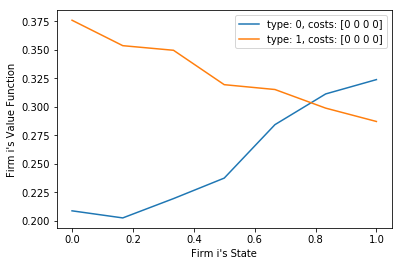

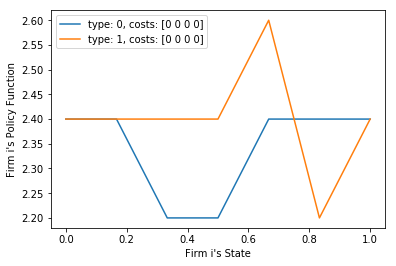

In [81]:
params =  2.5, -.3, 2, .2 , .1, .3, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 70, 6, params)

#play with initial policy
value,  policy = markov_perfect_eq(.0001, 100, value, policy, bids, states, shocks, params)

#generate states for graphing
graph_shocks = np.array([[0,0,0,0]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
policy0, ic = ic_policy_helper(value, policy, bids, states, graph_shocks, params)
graph_functions(value, policy0, cross_states, cross_shocks, ['Value','Policy'], [0,1])

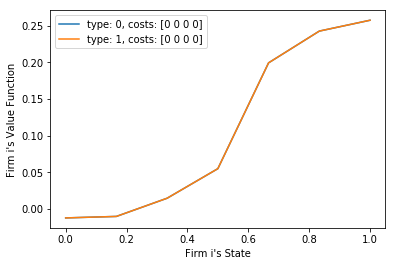

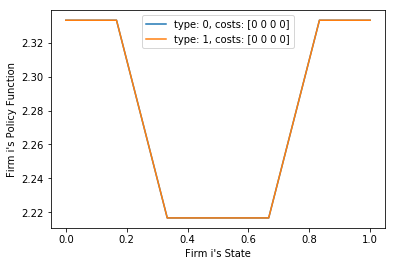

In [82]:
params =  2.5, -.3, 2.5, -.3, .1, .3, .9 #beta comes lasts
value, policy, bids, states, shocks, params = set_up_env(3, 70, 6, params)

#play with initial policy
value,  policy = markov_perfect_eq(.0001, 100, value, policy, bids, states, shocks, params)

#generate states for graphing
graph_shocks = np.array([[0,0,0,0]])
cross_states, cross_shocks = gen_cross(states, graph_shocks)

#roll the operator forward using shocks I intend to graph
policy0, ic = ic_policy_helper(value, policy, bids, states, graph_shocks, params)
graph_functions(value, policy0, cross_states, cross_shocks, ['Value','Policy'], [0,1])

In [ ]:
def save_functions(policy, value, states, shocks, fnames=('funcs/value.csv','funcs/policy.csv')):
    """easily save the points in a policy/value function (so I don't need to re-run code)"""
    
    n, n_states, n_shocks = states.n, states.get_len(), shocks.shape[0] 
    
    #save policy
    all_states, all_shocks = gen_all_shocks(states, cost_shocks, type_shocks)
    all_policy = policy(all_states,all_costs)
    all_policy = all_policy.reshape(all_types.shape[0],1)
    all_types = all_types.reshape(all_types.shape[0],1)
    policy_file = np.concatenate((all_states.get_all(get_types=True) , all_costs, all_types, all_policy), axis=1)
    
    policy_meta = np.zeros((1,policy_file.shape[1]))
    policy_meta[0,0:3] = n, n_states, n_shocks
    policy_file = np.concatenate( (policy_meta, policy_file), axis=0)
    np.savetxt(fnames[1], policy_file, delimiter=",")
    
    #save value
    all_value = value(states)
    all_value = all_value.reshape(all_value.shape[0],1)
    value_file = np.concatenate((states.get_all(get_types=True), all_value),axis=1)
    value_meta = policy_meta[:,0:value_file.shape[1]]
    value_file = np.concatenate( (value_meta, value_file), axis=0)
    np.savetxt(fnames[0], value_file, delimiter=",")

    
    
def load_functions(value_name, policy_name):
    """easily save the points in a policy function (so I don't need to re-run code)"""
    
    
    value_file = np.genfromtxt(value_name, delimiter=',')
    n, n_states, n_shocks = value_file[0,0:3] 
    value_file = value_file[1:,:]
    value = lambda s0: griddata(value_file[:,:-1], value_file[:,-1], s0.get_all(get_types=True),
                               method='nearest',rescale=True)
    
    
    policy_file  = np.genfromtxt(policy_name, delimiter=',')
    n, n_states, n_shocks = policy_file[0,0:3]
    policy_file = policy_file[1:,:]
    policy = lambda s0, e0: griddata(policy_file[:,:-2], policy_file[:,-1], 
                            np.concatenate( (s0.get_all(get_types=True,order=True),e0), axis=1), method='nearest',rescale=True)
    return value, policy
    
    

value0, policy0 = load_functions('funcs/value.csv', 'funcs/policy.csv')
save_functions(policy0,value0,states,cost_shocks,type_shocks)

In [ ]:
#value, policy = load_functions('funcs/value.csv', 'funcs/policy.csv')
#save_functions(policy,value,states,cost_shocks,type_shocks)

In [ ]:
init_states = states.make_states([.3,.4],[[.3,.3],[.1,.3]],[0,1])

def follow_path(value, policy, init_state, shocks, params, fname):
    """given value and policy functions, roll forward through the markov process"""
    
    obsv = []
    current_state= init_state
    for i in range(cost_shocks.shape[0]):
        all_bids = calc_bids(policy,  current_state, cost_shocks[i:i+1,:], start=0)
        
        #2 bugs here. states don't udpate right/ types and who won...
        all_profit = profit(all_bids, current_state, cost_shocks[i:i+1,:], params)
        row = np.concatenate((current_state.get_all(get_types=True),all_bids,all_profit,cost_shocks[i:i+1,:],
                              [type_shocks[i]]),axis=1)
        
        #update loop variable
        obsv.append(row[0,:])
        current_state = update_state(all_bids, current_state, type_shocks[i], params, order=False)
        
    
    h1 = 'state,'*states.n+ 'type,'+ 'bid,'*states.n+'profit,'*states.n+'shock,'*states.n+'shock2,'
    
    obsv=np.array(obsv)
    np.savetxt(fname, obsv, delimiter=",", header=h1)
    
    
new_states = states.make_states([.3],[[.3,.3]],[1])
follow_path(value, policy, new_states, cost_shocks, type_shocks, params, 'test.csv')